<a href="https://colab.research.google.com/github/michaelachmann/social-media-lab/blob/main/notebooks/2024_11_25_GPT_Text_Classification_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GPT Text Classification [![DOI](https://zenodo.org/badge/660157642.svg)](https://zenodo.org/badge/latestdoi/660157642)
![Notes on (Computational) Social Media Research Banner](https://raw.githubusercontent.com/michaelachmann/social-media-lab/main/images/banner.png)

## Overview

This Jupyter notebook is a part of the social-media-lab.net project, which is a work-in-progress textbook on computational social media analysis. The notebook is intended for use in my classes.

The **GPT Text Classification V2** Notebook provides python code to use GPT for text classification in a loop.

### Project Information

- Project Website: [social-media-lab.net](https://social-media-lab.net/)
- GitHub Repository: [https://github.com/michaelachmann/social-media-lab](https://github.com/michaelachmann/social-media-lab)

## License Information

This notebook, along with all other notebooks in the project, is licensed under the following terms:

- License: [GNU General Public License version 3.0 (GPL-3.0)](https://www.gnu.org/licenses/gpl-3.0.de.html)
- License File: [LICENSE.md](https://github.com/michaelachmann/social-media-lab/blob/main/LICENSE.md)


## Citation

If you use or reference this notebook in your work, please cite it appropriately. Here is an example of the citation:

```
Michael Achmann. (2024). michaelachmann/social-media-lab: 2024-11-25 (v0.0.15). Zenodo. https://doi.org/10.5281/zenodo.8199901
```

## Updates 2024
* Removed the "Cost Saving" section, see website for archive.
* Added the section for structured Output
* 🔧 The notebook still needs some small fixes and improvements.

Some of the prompts used below have been used in our paper [Detecting Calls to Action in Multimodal Content: Analysis of the 2021 German Federal Election Campaign on Instagram](https://aclanthology.org/2024.cpss-1.1) (Achmann-Denkler et al., cpss-WS 2024).

## Let's read last week's Text DataFrame

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/2023-12-01-Export-Posts-Text-Master.csv')

In [ ]:
df.head()

,Unnamed: 0.1,Unnamed: 0,shortcode,Text,Text Type,Policy Issues,Sentiment,identifier
0,0,0,CyMAe_tufcR,#Landtagswahl23 🤩🧡🙏 #FREIEWÄHLER #Aiwanger #Da...,Caption,['1. Political parties:\n- FREIEWÄHLER\n- Aiwa...,positive,CyMAe_tufcR-Caption
1,1,1,CyL975vouHU,Die Landtagswahl war für uns als Liberale hart...,Caption,['Landtagswahl'],neutral,CyL975vouHU-Caption
2,2,2,CyL8GWWJmci,Nach einem starken Wahlkampf ein verdientes Er...,Caption,['1. Wahlkampf und Wahlergebnis:\n- Wahlkampf\...,positive,CyL8GWWJmci-Caption
3,3,3,CyL7wyJtTV5,So viele Menschen am Odeonsplatz heute mit ein...,Caption,"['Israel', 'Terrorismus', 'Hamas', 'Entwicklun...",negative,CyL7wyJtTV5-Caption
4,4,4,CyLxwHuvR4Y,Herzlichen Glückwunsch zu diesem grandiosen Wa...,Caption,['1. Wahlsieg und Parlamentseinstieg\n- Wahlsi...,positive,CyLxwHuvR4Y-Caption


In my [video on GPT text classification](https://youtu.be/QcYGwC4QzW0) I mentioned the problem of the unique identifier. Use the code below to create a unique identifier, for the use with multidocument classification and next session's human annotation.

In [ ]:
df['identifier'] = df.apply(lambda x: f"{x['shortcode']}-{x['Text Type']}", axis=1)

In [ ]:
df.head()

,Unnamed: 0.1,Unnamed: 0,shortcode,Text,Text Type,Policy Issues,Sentiment,identifier
0,0,0,CyMAe_tufcR,#Landtagswahl23 🤩🧡🙏 #FREIEWÄHLER #Aiwanger #Da...,Caption,['1. Political parties:\n- FREIEWÄHLER\n- Aiwa...,positive,CyMAe_tufcR-Caption
1,1,1,CyL975vouHU,Die Landtagswahl war für uns als Liberale hart...,Caption,['Landtagswahl'],neutral,CyL975vouHU-Caption
2,2,2,CyL8GWWJmci,Nach einem starken Wahlkampf ein verdientes Er...,Caption,['1. Wahlkampf und Wahlergebnis:\n- Wahlkampf\...,positive,CyL8GWWJmci-Caption
3,3,3,CyL7wyJtTV5,So viele Menschen am Odeonsplatz heute mit ein...,Caption,"['Israel', 'Terrorismus', 'Hamas', 'Entwicklun...",negative,CyL7wyJtTV5-Caption
4,4,4,CyLxwHuvR4Y,Herzlichen Glückwunsch zu diesem grandiosen Wa...,Caption,['1. Wahlsieg und Parlamentseinstieg\n- Wahlsi...,positive,CyLxwHuvR4Y-Caption


In [ ]:
df.to_csv('/content/drive/MyDrive/2023-12-01-Export-Posts-Text-Master.csv')

### Setup for GPT

In [ ]:
!pip install -q openai backoff gpt-cost-estimator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.4 MB/s eta 0:00:00


In [ ]:
import openai
from openai import OpenAI
from google.colab import userdata
import backoff
from gpt_cost_estimator import CostEstimator


#@title Setup for the OpenAI API

#@markdown We're using the new Colab Feature to store keys safely within the Colab Environment.
#@markdown Click on the key on the left to add your API key and enable it for this notebook.
#@markdown Enter the name of your API-Key below.
api_key_name = "openai-forschung-mad" # @param {type: "string"}
api_key = userdata.get(api_key_name)

# Initialize OpenAI using the key
client = OpenAI(
    api_key=api_key
)



@CostEstimator()
def query_openai(model, temperature, messages, mock=True, completion_tokens=10):
    return client.chat.completions.create(
                      model=model,
                      temperature=temperature,
                      messages=messages,
                      max_tokens=600)

# We define the run_request method to wrap it with the @backoff decorator
@backoff.on_exception(backoff.expo, (openai.RateLimitError, openai.APIError))
def run_request(system_prompt, user_prompt, model, mock):
  messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": user_prompt}
  ]

  return query_openai(
          model=model,
          temperature=0.0,
          messages=messages,
          mock=mock
        )

Next, we create a system prompt describing what we want to extract. For further examples of prompts and advice on prompt engineering see e.g. [the prompting guide](https://www.promptingguide.ai/introduction/examples#information-extraction) and further resources linked at the bottom of the page.

For the initial example we use social media content shared by politicans and parties. We know, that some of these texts mention policy issues, let's try to extract these issues across all documents.

**Note:** The extracted issues are not going to be consistent, because each document is sent as a singular request to the API, thus the previous issues are not going to be used as context.

Modify the following system prompt to extract other types of information. What else could you extract?
* Locations (based on names)
* Names (of persons or places)
* Mentions of Companies
* ...

Do not forget the **[Prompt Archive](https://uniregensburg-my.sharepoint.com/:x:/g/personal/acm53421_ads_uni-regensburg_de/EVgX8Avwyx5DvRUGugboTCkBPLxgrndfe6RPfsjGnMs8gA?rtime=jn_wv2zy20g)** when experimenting. Share your successfull prompt with us!

In [ ]:
system_prompt = """
You are an advanced classifying AI. Your task is to classify the sentiment of a text. Sentiment can be either ‘positive’, ‘negative’, or ‘neutral’.
"""

In [ ]:
prompt = """
Please classify the following social media comment into either ‘negative’, ‘neutral’, or ‘positive’. Your answer MUST be one of [‘negative’, ‘neutral’, ‘positive’], and it should be presented in lowercase.
Text: [TEXT]
"""

In [ ]:
from tqdm.auto import tqdm
#@title Running the request.
#@markdown The following code snippet uses my [gpt-cost-estimator](https://pypi.org/project/gpt-cost-estimator/) package to simulate API requests and calculate a cost estimate. Please run the estimation whne possible to asses the price-tag before sending requests to OpenAI!

#@markdown Make sure 'run_request' and 'system_prompt' are defined before this block by running the two blocks above!

#@markdown Do you want to mock the OpenAI request (dry run) to calculate the estimated price?
MOCK = False # @param {type: "boolean"}
#@markdown Do you want to reset the cost estimation when running the query?
RESET_COST = True # @param {type: "boolean"}
#@markdown What's the column name to save the results of the data extraction task to?
COLUMN = 'Sentiment' # @param {type: "string"}
#@markdown Do you want to run the request on a smaller sample of the whole data? (Useful for testing). Enter 0 to run on the whole dataset.
SAMPLE_SIZE = 25 # @param {type: "number", min: 0}

#@markdown Which model do you want to use?
MODEL = "gpt-4o-mini" # @param ["gpt-4o-mini", "gpt-4o"] {allow-input: true}


# Initializing the empty column
if COLUMN not in df.columns:
  df[COLUMN] = None

# Reset Estimates
CostEstimator.reset()
print("Reset Cost Estimation")

filtered_df = df.copy()

# Skip previously annotated rows
filtered_df = filtered_df[pd.isna(filtered_df[COLUMN])]

if SAMPLE_SIZE > 0:
  filtered_df = filtered_df.sample(SAMPLE_SIZE)

for index, row in tqdm(filtered_df.iterrows(), total=len(filtered_df)):
    try:
        p = prompt.replace('[TEXT]', row['Text'])
        response = run_request(system_prompt, p, MODEL, MOCK)

        if not MOCK:
          # Extract the response content
          # Adjust the following line according to the structure of the response
          r = response.choices[0].message.content

          # Update the 'new_df' DataFrame
          df.at[index, COLUMN] = r

    except Exception as e:
        print(f"An error occurred: {e}")
        # Optionally, handle the error (e.g., by logging or by setting a default value)

print()

Reset Cost Estimation


  0%|          | 0/25 [00:00<?, ?it/s]

Cost: $0.0000 | Total: $0.0005


In [ ]:
df[~pd.isna(df['Sentiment'])].head()

,Unnamed: 0.1,Unnamed: 0,shortcode,Text,Text Type,Policy Issues,Sentiment,identifier
0,0,0,CyMAe_tufcR,#Landtagswahl23 🤩🧡🙏 #FREIEWÄHLER #Aiwanger #Da...,Caption,['1. Political parties:\n- FREIEWÄHLER\n- Aiwa...,positive,CyMAe_tufcR-Caption
1,1,1,CyL975vouHU,Die Landtagswahl war für uns als Liberale hart...,Caption,['Landtagswahl'],neutral,CyL975vouHU-Caption
2,2,2,CyL8GWWJmci,Nach einem starken Wahlkampf ein verdientes Er...,Caption,['1. Wahlkampf und Wahlergebnis:\n- Wahlkampf\...,positive,CyL8GWWJmci-Caption
3,3,3,CyL7wyJtTV5,So viele Menschen am Odeonsplatz heute mit ein...,Caption,"['Israel', 'Terrorismus', 'Hamas', 'Entwicklun...",negative,CyL7wyJtTV5-Caption
4,4,4,CyLxwHuvR4Y,Herzlichen Glückwunsch zu diesem grandiosen Wa...,Caption,['1. Wahlsieg und Parlamentseinstieg\n- Wahlsi...,positive,CyLxwHuvR4Y-Caption


In [ ]:
# Save Results
df.to_csv('/content/drive/MyDrive/2023-12-01-Export-Posts-Text-Master.csv')

Let's plot the result for a first *big picture*

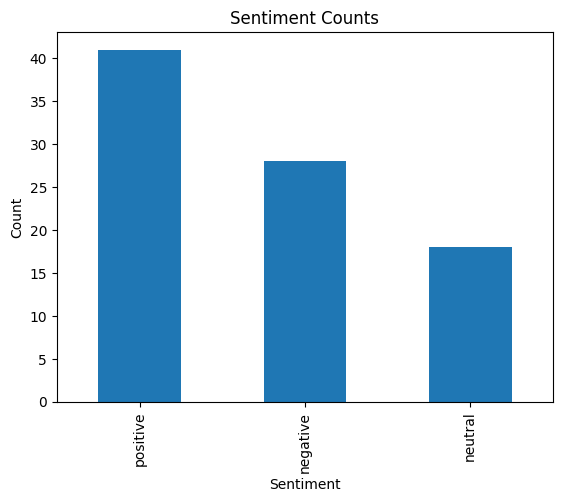

In [ ]:
import matplotlib.pyplot as plt

# Count the occurrences of each sentiment
sentiment_counts = df['Sentiment'].value_counts()

# Create a bar chart
sentiment_counts.plot(kind='bar')

# Adding labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Counts')

# Show the plot
plt.show()

### Extract Multiple Categories using JSON.

In [ ]:
system_prompt = """
You're an expert in detecting calls-to-action (CTAs) from texts.
**Objective:**
Determine the presence or absence of explicit and implicit CTAs within German-language content sourced from Instagram texts such as posts, stories, video transcriptions, and captions related to political campaigns from the given markdown table.
**Instructions:**
1. Examine each user input as follows:
2. Segment the content into individual sentences.
3. For each sentence, identify:
   a. Explicit CTA: Direct requests for an audience to act which are directed at the reader, e.g., "beide Stimmen CDU!", "Am 26. September #FREIEWÄHLER in den #Bundestag wählen."
   b. Explicit CTA: A clear direction on where or how to find additional information, e.g. "Mehr dazu findet ihr im Wahlprogramm auf fdp.de/vielzutun", "Besuche unsere Website für weitere Details."
   c. Implicit CTA: Suggestions or encouragements that subtly propose an action directed at the reader without a direct command, e.g., "findet ihr unter dem Link in unserer Story."
4. Classify whether an online or offline action is referrenced.
5. CTAs should be actions that the reader or voter can perform directly, like voting for a party, clicking a link, checking more information, etc. General statements, assertions, or suggestions not directed at the reader should not be classified as CTAs.
5. Return boolean variables for Implicit CTAs (`Implicit`), Explicit CTAs (`Explicit`), `Online`, and `Offline` as a JSON objet.
**Formatting:**
Only return the JSON object, nothing else. Do not repeat the text input.
"""

In [ ]:
from tqdm.auto import tqdm
import json

#@title Run the extraction of multiple variables.
#@markdown The following code snippet uses my [gpt-cost-estimator](https://pypi.org/project/gpt-cost-estimator/) package to simulate API requests and calculate a cost estimate. Please run the estimation whne possible to asses the price-tag before sending requests to OpenAI!<br/>

#@markdown **Note:** This code block adds some logic to deal with multiple variables contained in the JSON object: `{"Implicit": false, "Explicit": false, "Online": false, "Offline": false}`. We add the columns `Implicit`, `Explicit`, `Online`, and `Offline` accordingly. **To classify different variables the code need to be modified accordingly.** [ChatGPT can help with this task!](https://chat.openai.com/share/1a605945-14c0-4387-98e3-879380487d49)<br/></br>
#@markdown Make sure 'run_request' and 'system_prompt' are defined before this block by running the two blocks above!

#@markdown Do you want to mock the OpenAI request (dry run) to calculate the estimated price?
MOCK = False # @param {type: "boolean"}
#@markdown Do you want to reset the cost estimation when running the query?
RESET_COST = True # @param {type: "boolean"}
#@markdown Do you want to run the request on a smaller sample of the whole data? (Useful for testing). Enter 0 to run on the whole dataset.
SAMPLE_SIZE = 25 # @param {type: "number", min: 0}

#@markdown Which model do you want to use?
MODEL = "gpt-4o-mini" # @param ["gpt-4o-mini", "gpt-4o"] {allow-input: true}

#@markdown Which variables did you define in your Prompt?
COLUMNS = ["Implicit", "Explicit", "Online", "Offline"] # @param {type: "raw"}

# This method extracts the four variables from the response.
def extract_variables(response_str):
    # Initialize the dictionary
    extracted = {}

    for column in COLUMNS:
      extracted[column] = None

    try:
        # Parse the JSON string
        data = json.loads(response_str)

        for column in COLUMNS:
          # Extract variables
          extracted[column] = data.get(column, None)

        return extracted

    except json.JSONDecodeError:
        # Handle JSON decoding error (e.g., malformed JSON)
        print("Error: Response is not a valid JSON string.")
        return extracted
    except KeyError:
        # Handle cases where a key is missing
        print("Error: One or more keys are missing in the JSON object.")
        return extracted
    except Exception as e:
        # Handle any other exceptions
        print(f"An unexpected error occurred: {e}")
        return extracted


# Initializing the empty column
if COLUMN not in df.columns:
  df[COLUMN] = None

# Reset Estimates
CostEstimator.reset()
print("Reset Cost Estimation")

filtered_df = df.copy()

# Skip previously annotated rows
filtered_df = filtered_df[pd.isna(filtered_df[COLUMN])]

if SAMPLE_SIZE > 0:
  filtered_df = filtered_df.sample(SAMPLE_SIZE)

for index, row in tqdm(filtered_df.iterrows(), total=len(filtered_df)):
    try:
        p = row['Text']
        response = run_request(system_prompt, p, MODEL, MOCK)

        if not MOCK:
          # Extract the response content
          # Adjust the following line according to the structure of the response
          r = response.choices[0].message.content
          extracted = extract_variables(r)

          for column in COLUMNS:
            df.at[index, column] = extracted[column]

    except Exception as e:
        print(f"An error occurred: {e}")
        # Optionally, handle the error (e.g., by logging or by setting a default value)

print()

Reset Cost Estimation


  0%|          | 0/25 [00:00<?, ?it/s]

Cost: $0.0001 | Total: $0.0018


In [ ]:
df[~pd.isna(df['Implicit'])].head()

,Unnamed: 0.1,Unnamed: 0,shortcode,Text,Text Type,Policy Issues,Sentiment,identifier,Implicit,Explicit,Online,Offline
116,116,116,CyGH9ptIuaN,1️⃣. Kostenlose Kitas für 780.000 Kinder \n2️⃣...,Caption,"['Kostenlose Kitas für 780.000 Kinder', 'Gute ...",NaN,CyGH9ptIuaN-Caption,False,True,False,True
336,336,336,Cx5OPlco0u5,Deutschland braucht eine #Integrationsgrenze. ...,Caption,"['Integration', 'Migration']",NaN,Cx5OPlco0u5-Caption,False,True,False,True
342,342,342,Cx5HL0vobXI,Lena Rasilier - Unsere JU-Listenkandidatin für...,Caption,NaN,NaN,Cx5HL0vobXI-Caption,False,False,False,True
429,429,429,CxxzJAWoAS3,"#Bayern ist solidarisch, aber nicht naiv. Wir ...",Caption,"['Länderfinanzausgleich reformieren', 'bayeris...",NaN,CxxzJAWoAS3-Caption,False,True,False,True
612,612,612,CxlXbFdosaB,"✡️ Heute Abend beginnt Jom Kippur, der heiligs...",Caption,NaN,NaN,CxlXbFdosaB-Caption,False,False,False,False


## Few-Shot Classification

In [ ]:
system_prompt = """
You are an advanced classifying AI. Your task is to classify the sentiment of a text. Sentiment can be either ‘positive’, ‘negative’, or ‘neutral’.
**Examples:**
"Wir sind EIN Volk! 🇩🇪 In Leipzig nahm es den Anfang, breitete sich aus wie ein Lauffeuer und ebnete den Weg für die deutsche Einheit. Was damals viel Arbeit war, zahlte sich aus. Was heute noch Arbeit ist, wird sich auszahlen. Ein geeintes Deutschland ist keine Selbstverständlichkeit und wir sind dankbar für die Demokratie, den Rechtsstaat und unsere freiheitliche Gesellschaft. Und wir arbeiten täglich dafür, dass uns diese Werte erhalten bleiben.": positive
"FREIE WÄHLER Wir FREIE WÄHLER kämpfen für eine flächendeckende Gesundheitsversorgung auch auf dem Land. HUBERT AJUANGER": neutral
"Die #Grünen sind mit dafür verantwortlich, dass die #Ampel-Regierung in Berlin meilenweit an der Lebenswirklichkeit der Menschen vorbei regiert. Ausgerechnet unter einem grünen Klimaminister lässt die Akzeptanz für #Klimaschutz in der Gesellschaft nach. Mit uns wird es keine Grünen in der Bayerischen Staatsregierung geben.": negative
"""

In [ ]:
prompt = """
Please classify the following social media comment into either ‘negative’, ‘neutral’, or ‘positive’. Your answer MUST be one of [‘negative’, ‘neutral’, ‘positive’], and it should be presented in lowercase.
Text: [TEXT]
"""

In [ ]:
from tqdm.auto import tqdm
#@title Run the Few-Shot request.
#@markdown The following code snippet uses my [gpt-cost-estimator](https://pypi.org/project/gpt-cost-estimator/) package to simulate API requests and calculate a cost estimate. Please run the estimation whne possible to asses the price-tag before sending requests to OpenAI!

#@markdown Make sure 'run_request' and 'system_prompt' are defined before this block by running the two blocks above!

#@markdown Do you want to mock the OpenAI request (dry run) to calculate the estimated price?
MOCK = False # @param {type: "boolean"}
#@markdown Do you want to reset the cost estimation when running the query?
RESET_COST = True # @param {type: "boolean"}
#@markdown What's the column name to save the results of the data extraction task to?
COLUMN = 'Sentiment_Few_Shot' # @param {type: "string"}
#@markdown Do you want to run the request on a smaller sample of the whole data? (Useful for testing). Enter 0 to run on the whole dataset.
SAMPLE_SIZE = 25 # @param {type: "number", min: 0}

#@markdown Which model do you want to use?
MODEL = "gpt-4o-mini" # @param ["gpt-4o-mini", "gpt-4o"] {allow-input: true}


# Initializing the empty column
if COLUMN not in df.columns:
  df[COLUMN] = None

# Reset Estimates
CostEstimator.reset()
print("Reset Cost Estimation")

filtered_df = df.copy()

# Skip previously annotated rows
filtered_df = filtered_df[pd.isna(filtered_df[COLUMN])]

if SAMPLE_SIZE > 0:
  filtered_df = filtered_df.sample(SAMPLE_SIZE)

for index, row in tqdm(filtered_df.iterrows(), total=len(filtered_df)):
    try:
        p = prompt.replace('[TEXT]', row['Text'])
        response = run_request(system_prompt, p, MODEL, MOCK)

        if not MOCK:
          # Extract the response content
          # Adjust the following line according to the structure of the response
          r = response.choices[0].message.content

          # Update the 'new_df' DataFrame
          df.at[index, COLUMN] = r

    except Exception as e:
        print(f"An error occurred: {e}")
        # Optionally, handle the error (e.g., by logging or by setting a default value)

print()

Reset Cost Estimation


  0%|          | 0/25 [00:00<?, ?it/s]

Cost: $0.0000 | Total: $0.0009


In [ ]:
response.choices[0].message.content

'positive'

In [ ]:
df[~pd.isna(df['Sentiment_Few_Shot'])].sample(5)

,Unnamed: 0.1,Unnamed: 0,shortcode,Text,Text Type,Policy Issues,Sentiment,identifier,Implicit,Explicit,Online,Offline,Sentiment_Few_Shot
1247,1247,1247,Cw2_XRys9w9,🤝🤖 Nützlicher Helfer oder Terminator? Es liegt...,Caption,NaN,NaN,Cw2_XRys9w9-Caption,NaN,NaN,NaN,NaN,positive
2611,2611,2611,Cwp7CKpqpgH,Betrug am Wähler? Mit den Freien Wählern Bayer...,OCR,NaN,NaN,Cwp7CKpqpgH-OCR,NaN,NaN,NaN,NaN,negative
2525,2525,2525,Cw0SAceIOFo,HEIZGESETZ L STOPI LOS VON BERLIN BAYERNPARTE],OCR,NaN,NaN,Cw0SAceIOFo-OCR,NaN,NaN,NaN,NaN,negative
2390,2390,2390,CxA_hj5I9LI,5x 7al5 Gould Ik DEuTsEHLAND ING ING SHERZLICH...,OCR,NaN,NaN,CxA_hj5I9LI-OCR,NaN,NaN,NaN,NaN,positive
2497,2497,2497,Cw25aYLtTBG,WAS IST MIT MEINER HEIZUNG? Unser Heizungs-Lot...,OCR,NaN,NaN,Cw25aYLtTBG-OCR,NaN,NaN,NaN,NaN,neutral


In [ ]:
# Save Results
df.to_csv('/content/drive/MyDrive/2023-12-01-Export-Posts-Text-Master.csv')

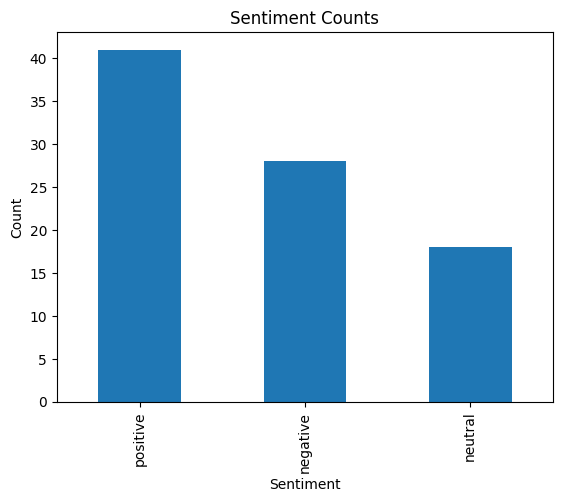

In [ ]:
import matplotlib.pyplot as plt

# Count the occurrences of each sentiment
sentiment_counts = df['Sentiment'].value_counts()

# Create a bar chart
sentiment_counts.plot(kind='bar')

# Adding labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Counts')

# Show the plot
plt.show()

## Advanced: JSON Output

In the code below we make use of the new models' `json_mode`. See the [OpenAI Documentation](https://platform.openai.com/docs/guides/structured-outputs) for more information.

* Additionally, we now send few-shots differently: We pass each example as a pair of user and system message.
* We save the response in a new dictionary and make use of the pandas `json_normalize` function. Saving classification results together with the model version makes the later evaluation stage easier.


In [50]:
@CostEstimator()
def query_openai(model, temperature, messages, response_format, mock=True, completion_tokens=10):
    return client.chat.completions.create(
                      model=model,
                      temperature=temperature,
                      messages=messages,
                      response_format=response_format,
                      max_tokens=600)

# We define the run_request method to wrap it with the @backoff decorator
@backoff.on_exception(backoff.expo, (openai.RateLimitError, openai.APIError))
def run_json_request(system_prompt, few_shot_messages, user_prompt, model, mock):

  messages = [
    {"role": "system", "content": system_prompt},
  ]

  for msg in few_shot_messages:
    message = {"role": "user", "content": msg['user']}
    messages.append(message)
    message = {"role": "system", "content": msg['system']}
    messages.append(message)

  messages.append({"role": "user", "content": user_prompt})

  return query_openai(
          model=model,
          temperature=0.0,
          messages=messages,
          response_format= {
            "type": "json_object",
          },
          mock=mock
        )

In [ ]:
system_prompt = """
You are an advanced classifying AI. Your task is to classify the sentiment of a text. Sentiment can be either ‘positive’, ‘negative’, or ‘neutral’.
Classify any user message into either ‘negative’, ‘neutral’, or ‘positive’. Your answer MUST be one of [‘negative’, ‘neutral’, ‘positive’].
Return a JSON dictionary {"sentiment": "negative"/"neutral"/"positive"}
"""

In [ ]:
few_shot_messages = [
    {
        'user': 'Wir sind EIN Volk! 🇩🇪 In Leipzig nahm es den Anfang, breitete sich aus wie ein Lauffeuer und ebnete den Weg für die deutsche Einheit. Was damals viel Arbeit war, zahlte sich aus. Was heute noch Arbeit ist, wird sich auszahlen. Ein geeintes Deutschland ist keine Selbstverständlichkeit und wir sind dankbar für die Demokratie, den Rechtsstaat und unsere freiheitliche Gesellschaft. Und wir arbeiten täglich dafür, dass uns diese Werte erhalten bleiben.',
        'system': '{"sentiment": "positive"}'},
    {
        'user': 'FREIE WÄHLER Wir FREIE WÄHLER kämpfen für eine flächendeckende Gesundheitsversorgung auch auf dem Land. HUBERT AJUANGER',
        'system': '{"sentiment": "neutral"}'},
    {
        "user": "Die #Grünen sind mit dafür verantwortlich, dass die #Ampel-Regierung in Berlin meilenweit an der Lebenswirklichkeit der Menschen vorbei regiert. Ausgerechnet unter einem grünen Klimaminister lässt die Akzeptanz für #Klimaschutz in der Gesellschaft nach. Mit uns wird es keine Grünen in der Bayerischen Staatsregierung geben.",
        "system": '{"sentiment": "negative"}'
    }
  ]

In [57]:
from tqdm.auto import tqdm
import json
#@title Run the Few-Shot request.
#@markdown The following code snippet uses my [gpt-cost-estimator](https://pypi.org/project/gpt-cost-estimator/) package to simulate API requests and calculate a cost estimate. Please run the estimation whne possible to asses the price-tag before sending requests to OpenAI!

#@markdown Make sure 'run_request' and 'system_prompt' are defined before this block by running the two blocks above!

#@markdown Do you want to mock the OpenAI request (dry run) to calculate the estimated price?
MOCK = False # @param {type: "boolean"}
#@markdown Do you want to reset the cost estimation when running the query?
RESET_COST = True # @param {type: "boolean"}
#@markdown What's the name of the identifier column?
IDENTIFIER_COLUMN = 'identifier' # @param {type: "string"}
#@markdown Do you want to run the request on a smaller sample of the whole data? (Useful for testing). Enter 0 to run on the whole dataset.
SAMPLE_SIZE = 25 # @param {type: "number", min: 0}

#@markdown Which model do you want to use?
MODEL = "gpt-4o-mini" # @param ["gpt-4o-mini", "gpt-4o"] {allow-input: true}


# Initializing the empty column
if COLUMN not in df.columns:
  df[COLUMN] = None

# Reset Estimates
CostEstimator.reset()
print("Reset Cost Estimation")

filtered_df = df.copy()

# Skip previously annotated rows
filtered_df = filtered_df[pd.isna(filtered_df[COLUMN])]

if SAMPLE_SIZE > 0:
  filtered_df = filtered_df.sample(SAMPLE_SIZE)

gpt_responses = []

for index, row in tqdm(filtered_df.iterrows(), total=len(filtered_df)):
    try:
        response = run_json_request(system_prompt, few_shot_messages, row['Text'], MODEL, MOCK)

        if not MOCK:
          # Extract the response content
          # Adjust the following line according to the structure of the response
          r = response.choices[0].message.content

          # Update the 'new_df' DataFrame
          gpt_responses.append({
              "identifier": row[IDENTIFIER_COLUMN],
              "text": row['Text'],
              MODEL: json.loads(r)
          })

    except Exception as e:
        print(f"An error occurred: {e}")
        # Optionally, handle the error (e.g., by logging or by setting a default value)
        gpt_responses.append({
            "identifier": row[IDENTIFIER_COLUMN],
            "text": row['Text'],
            MODEL: None
        })

gpt_responses_df = pd.json_normalize(gpt_responses)
print()

Reset Cost Estimation


  0%|          | 0/25 [00:00<?, ?it/s]

Cost: $0.0000 | Total: $0.0011


In [59]:
gpt_responses_df.head()

,identifier,text,gpt-4o-mini.sentiment
0,CxZ8IfFKc3d-Caption,"Zum #Weltkindertag fordern wir, wie @janine_wi...",positive
1,CxprdkyNizu-Caption,Beim größten rechtsterroristischen Anschlag de...,positive
2,CxpSm8MN_S_-Caption,"Ob in die Arbeit, zu Freund*innen oder zum Spo...",positive
3,CxFnOukKPPV-OCR,DIE IM BUNDESHAUSHALT VORGESEHENEN MITTELKURZU...,negative
4,CxNEcbKtWwp-OCR,8 nam Schulze Schardt,neutral


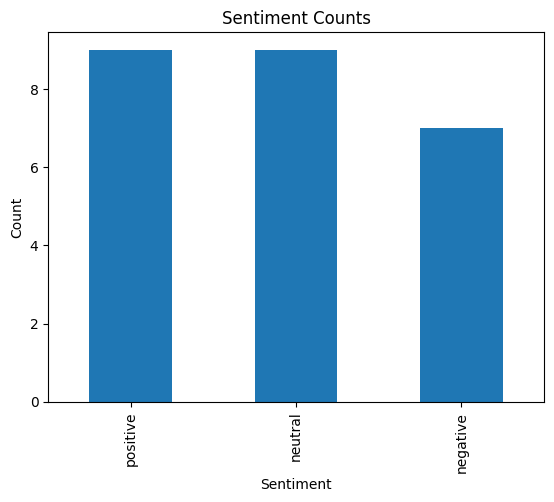

In [60]:
import matplotlib.pyplot as plt

# Count the occurrences of each sentiment
sentiment_counts = gpt_responses_df['gpt-4o-mini.sentiment'].value_counts()

# Create a bar chart
sentiment_counts.plot(kind='bar')

# Adding labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Counts')

# Show the plot
plt.show()